# Human iris center calculation

## importing libraries 

In [1]:
from skimage.io import imread_collection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
from scipy import ndimage
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch. utils.data import DataLoader

## reading the images from the directory and convert them to gray scale

In [2]:
images_dir = 'images/*.png'
images_list = imread_collection(images_dir)
gray_images_list =[cv2.cvtColor(image, cv2.COLOR_BGR2GRAY ) for image in images_list]

## visualizing a sample.
you can change the im_num and see anthor one 

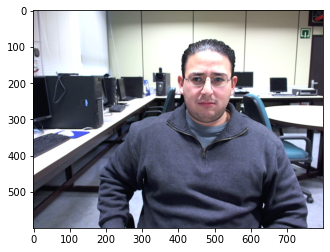

In [3]:
im_num=100
plt.imshow(images_list[im_num])

## visualizing a gray sample.

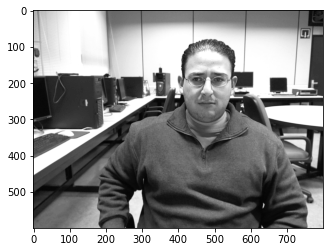

In [4]:
plt.imshow(gray_images_list[im_num], cmap='gray')


## reading the coordinates for the eye points and store them


In [5]:
with open('labels/image_labels.txt') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

In [6]:
lables=[lable.split()[1:] for lable in lines] 

In [7]:
for i,lable in enumerate( lables):
    lables[i]=[int(float(cor)) for cor in lable]#you can make rounde

## example of the coordinates

In [8]:
lables[im_num]

[523, 193, 511, 190, 500, 193, 464, 193, 451, 189, 442, 191]

## take an image and plot the dots on it 

In [9]:
temp_image=images_list[im_num].copy()

In [10]:
for x in range(0,12,2):
    temp_image=cv2.circle(temp_image, (lables[100][x],lables[100][x+1]), radius=2, color=(255, 255, 255),thickness=-1)
    

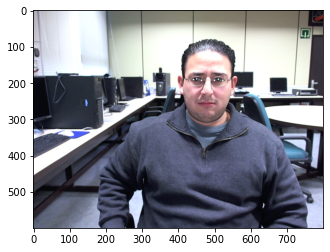

In [11]:
plt.imshow(temp_image)

## Normalizing images (divide by 255)

In [12]:
gray_images_list=[image/255 for image in gray_images_list]

## Cropping eye regions (and resize if needed) to be (48x48) image with the help of eye corners.
labels (Y) are coordinates of eye center for each image in X sorry for the long line but for the sake of details

In [13]:
X=[]
cen=[]
for i,image in enumerate(gray_images_list):
    yl= min(lables[i][1],lables[i][5])-int((47-abs(lables[i][1]-lables[i][5]))/2) if (47-abs(lables[i][1]-lables[i][5]))%2==0 else -1+min(lables[i][1],lables[i][5])-int((47-abs(lables[i][1]-lables[i][5]))/2)
    yr= min(lables[i][7],lables[i][11])-int((47-abs(lables[i][7]-lables[i][11]))/2) if (47-abs(lables[i][7]-lables[i][11]))%2==0 else -1+min(lables[i][7],lables[i][11])-int((47-abs(lables[i][7]-lables[i][11]))/2)
    xl= min(lables[i][0],lables[i][4])-int((47-abs(lables[i][0]-lables[i][4]))/2) if (47-abs(lables[i][0]-lables[i][4]))%2==0 else -1+min(lables[i][0],lables[i][4])-int((47-abs(lables[i][0]-lables[i][4]))/2)
    xr= min(lables[i][6],lables[i][10])-int((47-abs(lables[i][6]-lables[i][10]))/2) if (47-abs(lables[i][6]-lables[i][10]))%2==0 else -1+min(lables[i][6],lables[i][10])-int((47-abs(lables[i][6]-lables[i][10]))/2)
    
    X.append(image[yl:yl+48, xl:xl+48])
    X.append(image[yr:yr+48, xr:xr+48])
    
    cen.append((lables[i][2]-xl,lables[i][3]-yl))
    cen.append((lables[i][8]-xr,lables[i][9]-yr))

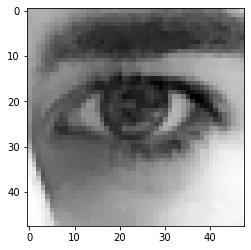

In [14]:
plt.imshow(X[im_num], cmap='gray')

In [15]:
temp=X[im_num].copy()

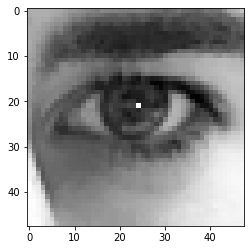

In [16]:
plt.imshow(cv2.circle(temp, (cen[im_num][0],cen[im_num][1]), radius=0, color=(1),thickness=-1),cmap='gray')

In [17]:
cen[im_num][0],cen[im_num][1]

(24, 21)

## creating black images with a white pixel that represent the center of iris

Applying dealation and gaussian blur effect on the Y image to make the training process more stable

In [18]:
Y=[]
kernel = np.ones((2, 2), 'uint8')
for cent in cen:
    black_image_with_center = cv2.circle(np.zeros((48,48)), (cent[0],cent[1]), radius=0, color=(255),thickness=-1)
    dilated_image = cv2.dilate(black_image_with_center, kernel, iterations=1)
    gaussianblured_image = cv2.GaussianBlur(dilated_image,(3,3),1)
    Y.append(gaussianblured_image)

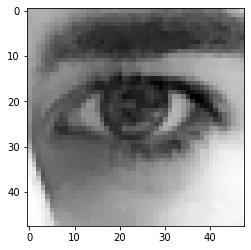

In [19]:
plt.imshow(X[im_num], cmap='gray')

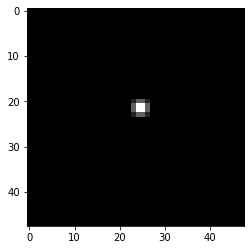

In [20]:
plt.imshow(Y[im_num], cmap='gray')

## creating the data loader for our dataset from X and Y and split it to 20% test 80% train

In [21]:
from torch.utils.data import TensorDataset, DataLoader
import torch.utils.data as data_utils

inputs = X.copy()
targets = Y.copy()
batch_size = 64
test_batch_size = 1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=431)
train_inputs  = torch.tensor(X_train,dtype=torch.float)
train_targets = torch.tensor(y_train,dtype=torch.float)
train_inputs = train_inputs[:,None,:,:]
train_targets = train_targets[:,None,:,:]

train_dataset =TensorDataset(train_inputs, train_targets)
train_data_loader = DataLoader(train_dataset, batch_size, shuffle = True)

test_inputs  = torch.tensor(X_test,dtype=torch.float)
test_targets = torch.tensor(y_test,dtype=torch.float)
test_inputs = test_inputs[:,None,:,:]
test_targets = test_targets[:,None,:,:]

test_dataset =TensorDataset(test_inputs, test_targets)
test_data_loader = DataLoader(test_dataset, test_batch_size, shuffle = True)


C:\AI\envs\gpupy\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  if __name__ == '__main__':


In [22]:
len(train_dataset)

1977

In [23]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [24]:
print(device)

cuda:0


## building the model

In [25]:
class Net(nn.Module):
        
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1  , 64 , 3, padding=1 ) 
        self.conv2 = nn.Conv2d(64 , 128, 25, padding=0 )
        self.conv3 = nn.Conv2d(128 , 256, 13, padding=0 )
        self.dconv3 = nn.ConvTranspose2d(256, 64, 3, stride=4,output_padding=1)
        self.conv5 = nn.Conv2d(128, 64 , 3 , padding=1 ) 
        self.conv6 = nn.Conv2d(64 , 1  , 3 , padding=1 ) 
        self.dconv1d = nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1 ) 
        self.dconv2d = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1 , output_padding=1) 
        self.dconv3d = nn.ConvTranspose2d(128, 64 , 3, stride=2, padding=1 , output_padding=1) 
        self.conv4d = nn.Conv2d(64 , 1  , 3 , padding=1 ) 


    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x1))
        xenc = F.relu(self.conv3(x))
        xd = F.relu(self.dconv3(xenc))
        x = torch.cat((x1,xd), 1)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        d = F.relu(self.dconv1d(xenc))
        d = F.relu(self.dconv2d(d))
        d = F.relu(self.dconv3d(d))
        d = F.relu(self.conv4d(d))
        return x,d

net = Net().to(device)
net

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(25, 25), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(13, 13), stride=(1, 1))
  (dconv3): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(4, 4), output_padding=(1, 1))
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv1d): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2d): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dconv3d): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv4d): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## choosing the loss function and optimizer

In [26]:
loss_fun = torch.nn.MSELoss()

optim = torch.optim.Adamax(net.parameters(),lr=0.001,weight_decay=0.0001)

## create the train and test functions 

In [27]:
def train(base, device, data_loader, loss_fn, optimizer):
    base.train()
    train_loss = []
    for image, cen in data_loader:
        optimizer.zero_grad()
        image = image.to(device)    
        base_image,decoded_image = base(image)
        loss1 = loss_fn(base_image, cen.to(device))
        loss2 = loss_fn(decoded_image, image)
        loss=loss1+loss2
        loss.backward()
        optimizer.step()
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)
def test(base, device, data_loader, loss_fn):
    test_loss = []
    for image, cen in data_loader:
        image = image.to(device)    
        base_image,decoded_image = base(image)
        loss1 = loss_fn(base_image, cen.to(device))
        loss2 = loss_fn(decoded_image, image)
        loss=loss1+loss2
        test_loss.append(loss.detach().cpu().numpy())

    return np.mean(test_loss)

## building the train loop and choosing the number of epochs, and i found the best combination is adamax, mse, and relu.

In [28]:
num_epochs = 100
for epoch in range(num_epochs):
    train_loss =train(net,device,train_data_loader,loss_fun,optim)
    print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,train_loss))

	 partial train loss (single batch): 41.100071
	 partial train loss (single batch): 41.850609
	 partial train loss (single batch): 40.988274
	 partial train loss (single batch): 41.032158
	 partial train loss (single batch): 41.024952
	 partial train loss (single batch): 40.953506
	 partial train loss (single batch): 41.014431
	 partial train loss (single batch): 40.912361
	 partial train loss (single batch): 40.928829
	 partial train loss (single batch): 40.935013
	 partial train loss (single batch): 40.914112
	 partial train loss (single batch): 40.886845
	 partial train loss (single batch): 40.882912
	 partial train loss (single batch): 40.868801
	 partial train loss (single batch): 40.873878
	 partial train loss (single batch): 40.853596
	 partial train loss (single batch): 40.849537
	 partial train loss (single batch): 40.845165
	 partial train loss (single batch): 40.858479
	 partial train loss (single batch): 40.845947
	 partial train loss (single batch): 40.840519
	 partial tra

	 partial train loss (single batch): 37.763718
	 partial train loss (single batch): 37.455620
	 partial train loss (single batch): 37.405891
	 partial train loss (single batch): 37.305153
	 partial train loss (single batch): 37.267223
	 partial train loss (single batch): 36.859081
	 partial train loss (single batch): 36.990875
	 partial train loss (single batch): 37.470722
	 partial train loss (single batch): 37.549313
	 partial train loss (single batch): 36.995617
	 partial train loss (single batch): 37.123455
	 partial train loss (single batch): 37.181419
	 partial train loss (single batch): 37.062538
	 partial train loss (single batch): 37.011227
	 partial train loss (single batch): 37.540668
	 partial train loss (single batch): 37.027390

 EPOCH 6/100 	 train loss 37.36740493774414
	 partial train loss (single batch): 36.981842
	 partial train loss (single batch): 37.099945
	 partial train loss (single batch): 36.962978
	 partial train loss (single batch): 36.878635
	 partial train

	 partial train loss (single batch): 35.873745

 EPOCH 11/100 	 train loss 35.77685546875
	 partial train loss (single batch): 35.508953
	 partial train loss (single batch): 35.114727
	 partial train loss (single batch): 35.319386
	 partial train loss (single batch): 35.794304
	 partial train loss (single batch): 35.628643
	 partial train loss (single batch): 36.047142
	 partial train loss (single batch): 35.736584
	 partial train loss (single batch): 35.617485
	 partial train loss (single batch): 35.547169
	 partial train loss (single batch): 35.985718
	 partial train loss (single batch): 35.727493
	 partial train loss (single batch): 35.913647
	 partial train loss (single batch): 35.895699
	 partial train loss (single batch): 35.348213
	 partial train loss (single batch): 35.592808
	 partial train loss (single batch): 35.178715
	 partial train loss (single batch): 35.563404
	 partial train loss (single batch): 35.574913
	 partial train loss (single batch): 35.193333
	 partial train l

	 partial train loss (single batch): 34.128536
	 partial train loss (single batch): 34.756023
	 partial train loss (single batch): 35.466541
	 partial train loss (single batch): 34.816677
	 partial train loss (single batch): 34.281796
	 partial train loss (single batch): 34.721886
	 partial train loss (single batch): 34.948368
	 partial train loss (single batch): 35.122635
	 partial train loss (single batch): 34.634335
	 partial train loss (single batch): 33.990360
	 partial train loss (single batch): 35.521866
	 partial train loss (single batch): 34.187160
	 partial train loss (single batch): 34.466629
	 partial train loss (single batch): 34.182636
	 partial train loss (single batch): 35.302425
	 partial train loss (single batch): 34.141388
	 partial train loss (single batch): 34.416687
	 partial train loss (single batch): 34.991009

 EPOCH 17/100 	 train loss 34.65009307861328
	 partial train loss (single batch): 35.181351
	 partial train loss (single batch): 34.421410
	 partial trai

	 partial train loss (single batch): 33.835197
	 partial train loss (single batch): 33.992516
	 partial train loss (single batch): 34.555264

 EPOCH 22/100 	 train loss 34.170005798339844
	 partial train loss (single batch): 34.383427
	 partial train loss (single batch): 33.586498
	 partial train loss (single batch): 33.510395
	 partial train loss (single batch): 34.187286
	 partial train loss (single batch): 33.707771
	 partial train loss (single batch): 34.389469
	 partial train loss (single batch): 33.765079
	 partial train loss (single batch): 33.200874
	 partial train loss (single batch): 33.840622
	 partial train loss (single batch): 33.335709
	 partial train loss (single batch): 33.632622
	 partial train loss (single batch): 34.093147
	 partial train loss (single batch): 34.125748
	 partial train loss (single batch): 34.332943
	 partial train loss (single batch): 33.083794
	 partial train loss (single batch): 33.387413
	 partial train loss (single batch): 33.480175
	 partial tra

	 partial train loss (single batch): 33.869793
	 partial train loss (single batch): 32.968849
	 partial train loss (single batch): 32.183140
	 partial train loss (single batch): 32.185341
	 partial train loss (single batch): 33.586411
	 partial train loss (single batch): 33.308723
	 partial train loss (single batch): 33.270660
	 partial train loss (single batch): 31.569073
	 partial train loss (single batch): 32.213757
	 partial train loss (single batch): 32.825397
	 partial train loss (single batch): 32.535774
	 partial train loss (single batch): 32.647018
	 partial train loss (single batch): 33.401524
	 partial train loss (single batch): 33.072327
	 partial train loss (single batch): 33.293674
	 partial train loss (single batch): 33.025833
	 partial train loss (single batch): 32.778988
	 partial train loss (single batch): 33.192768
	 partial train loss (single batch): 32.182400
	 partial train loss (single batch): 33.247211

 EPOCH 28/100 	 train loss 32.859588623046875
	 partial tra

	 partial train loss (single batch): 31.040693
	 partial train loss (single batch): 32.311367
	 partial train loss (single batch): 31.875536
	 partial train loss (single batch): 32.170776
	 partial train loss (single batch): 31.883835

 EPOCH 33/100 	 train loss 32.063812255859375
	 partial train loss (single batch): 31.455845
	 partial train loss (single batch): 32.082741
	 partial train loss (single batch): 33.145676
	 partial train loss (single batch): 32.497993
	 partial train loss (single batch): 32.019627
	 partial train loss (single batch): 32.127895
	 partial train loss (single batch): 32.929127
	 partial train loss (single batch): 32.010509
	 partial train loss (single batch): 32.141876
	 partial train loss (single batch): 32.690617
	 partial train loss (single batch): 32.448925
	 partial train loss (single batch): 33.040268
	 partial train loss (single batch): 31.424948
	 partial train loss (single batch): 32.813408
	 partial train loss (single batch): 31.583393
	 partial tra

	 partial train loss (single batch): 31.667610
	 partial train loss (single batch): 31.162424
	 partial train loss (single batch): 30.856159
	 partial train loss (single batch): 31.465456
	 partial train loss (single batch): 31.246592
	 partial train loss (single batch): 31.450151
	 partial train loss (single batch): 31.758268
	 partial train loss (single batch): 30.611713
	 partial train loss (single batch): 31.153496
	 partial train loss (single batch): 30.812735
	 partial train loss (single batch): 34.470108
	 partial train loss (single batch): 31.504637
	 partial train loss (single batch): 32.399780
	 partial train loss (single batch): 31.605091
	 partial train loss (single batch): 31.404634
	 partial train loss (single batch): 31.140255
	 partial train loss (single batch): 31.661699
	 partial train loss (single batch): 31.224422
	 partial train loss (single batch): 30.850330
	 partial train loss (single batch): 31.712320
	 partial train loss (single batch): 30.988815
	 partial tra

	 partial train loss (single batch): 30.470615
	 partial train loss (single batch): 29.912210
	 partial train loss (single batch): 29.846464
	 partial train loss (single batch): 30.497997
	 partial train loss (single batch): 30.223001
	 partial train loss (single batch): 30.281006
	 partial train loss (single batch): 30.549288

 EPOCH 44/100 	 train loss 30.65595054626465
	 partial train loss (single batch): 30.739416
	 partial train loss (single batch): 31.161472
	 partial train loss (single batch): 29.974558
	 partial train loss (single batch): 31.072247
	 partial train loss (single batch): 31.072178
	 partial train loss (single batch): 29.607056
	 partial train loss (single batch): 32.072464
	 partial train loss (single batch): 30.561871
	 partial train loss (single batch): 30.426807
	 partial train loss (single batch): 30.649969
	 partial train loss (single batch): 29.749969
	 partial train loss (single batch): 30.357252
	 partial train loss (single batch): 30.341806
	 partial trai

	 partial train loss (single batch): 28.928043
	 partial train loss (single batch): 30.148012
	 partial train loss (single batch): 28.714640
	 partial train loss (single batch): 30.356096
	 partial train loss (single batch): 28.742037
	 partial train loss (single batch): 29.990896
	 partial train loss (single batch): 27.953558
	 partial train loss (single batch): 29.716887
	 partial train loss (single batch): 30.506767
	 partial train loss (single batch): 30.804176
	 partial train loss (single batch): 29.152725
	 partial train loss (single batch): 29.215992
	 partial train loss (single batch): 30.174545
	 partial train loss (single batch): 29.698511
	 partial train loss (single batch): 29.838394
	 partial train loss (single batch): 29.045866
	 partial train loss (single batch): 28.937052
	 partial train loss (single batch): 30.330778
	 partial train loss (single batch): 28.185362
	 partial train loss (single batch): 31.377304
	 partial train loss (single batch): 29.945631
	 partial tra

	 partial train loss (single batch): 28.451199
	 partial train loss (single batch): 29.600283
	 partial train loss (single batch): 29.350029
	 partial train loss (single batch): 27.841166
	 partial train loss (single batch): 29.120892
	 partial train loss (single batch): 30.184925
	 partial train loss (single batch): 30.567684
	 partial train loss (single batch): 29.206816
	 partial train loss (single batch): 29.575378

 EPOCH 55/100 	 train loss 28.83185386657715
	 partial train loss (single batch): 28.812201
	 partial train loss (single batch): 29.899628
	 partial train loss (single batch): 27.655678
	 partial train loss (single batch): 29.123138
	 partial train loss (single batch): 28.269302
	 partial train loss (single batch): 28.863354
	 partial train loss (single batch): 30.319992
	 partial train loss (single batch): 29.404064
	 partial train loss (single batch): 28.216238
	 partial train loss (single batch): 27.391247
	 partial train loss (single batch): 27.565817
	 partial trai

	 partial train loss (single batch): 28.183268
	 partial train loss (single batch): 29.304585
	 partial train loss (single batch): 27.433567
	 partial train loss (single batch): 27.406862
	 partial train loss (single batch): 27.750504
	 partial train loss (single batch): 27.818029
	 partial train loss (single batch): 27.836378
	 partial train loss (single batch): 27.925983
	 partial train loss (single batch): 27.986032
	 partial train loss (single batch): 30.120497
	 partial train loss (single batch): 27.398294
	 partial train loss (single batch): 28.789648
	 partial train loss (single batch): 27.541208
	 partial train loss (single batch): 27.057570
	 partial train loss (single batch): 26.999043
	 partial train loss (single batch): 28.603403
	 partial train loss (single batch): 27.543324
	 partial train loss (single batch): 27.804321
	 partial train loss (single batch): 26.529613
	 partial train loss (single batch): 26.774664
	 partial train loss (single batch): 28.915255
	 partial tra

	 partial train loss (single batch): 28.023993
	 partial train loss (single batch): 27.296360
	 partial train loss (single batch): 28.699152
	 partial train loss (single batch): 28.388763
	 partial train loss (single batch): 27.147577
	 partial train loss (single batch): 27.175447
	 partial train loss (single batch): 28.781532
	 partial train loss (single batch): 27.139038
	 partial train loss (single batch): 27.268772
	 partial train loss (single batch): 27.320175
	 partial train loss (single batch): 26.625401

 EPOCH 66/100 	 train loss 27.402259826660156
	 partial train loss (single batch): 27.530916
	 partial train loss (single batch): 25.749729
	 partial train loss (single batch): 28.443718
	 partial train loss (single batch): 27.553286
	 partial train loss (single batch): 27.558622
	 partial train loss (single batch): 27.016420
	 partial train loss (single batch): 27.402033
	 partial train loss (single batch): 27.718876
	 partial train loss (single batch): 26.946087
	 partial tra

	 partial train loss (single batch): 27.546547
	 partial train loss (single batch): 25.897018
	 partial train loss (single batch): 25.654137
	 partial train loss (single batch): 27.529383
	 partial train loss (single batch): 26.258205
	 partial train loss (single batch): 27.443329
	 partial train loss (single batch): 24.869637
	 partial train loss (single batch): 26.247047
	 partial train loss (single batch): 27.690575
	 partial train loss (single batch): 27.347956
	 partial train loss (single batch): 24.880409
	 partial train loss (single batch): 26.301411
	 partial train loss (single batch): 25.216024
	 partial train loss (single batch): 25.272867
	 partial train loss (single batch): 28.001804
	 partial train loss (single batch): 27.885885
	 partial train loss (single batch): 25.357651
	 partial train loss (single batch): 24.274389
	 partial train loss (single batch): 25.329981
	 partial train loss (single batch): 25.796288
	 partial train loss (single batch): 26.565645
	 partial tra

	 partial train loss (single batch): 26.886295
	 partial train loss (single batch): 26.697796
	 partial train loss (single batch): 26.209259
	 partial train loss (single batch): 27.428799
	 partial train loss (single batch): 24.379686
	 partial train loss (single batch): 27.201258
	 partial train loss (single batch): 25.990597
	 partial train loss (single batch): 27.359617
	 partial train loss (single batch): 24.719978
	 partial train loss (single batch): 25.023197
	 partial train loss (single batch): 26.611477
	 partial train loss (single batch): 24.534809
	 partial train loss (single batch): 26.119577

 EPOCH 77/100 	 train loss 25.85993194580078
	 partial train loss (single batch): 25.146393
	 partial train loss (single batch): 26.820127
	 partial train loss (single batch): 25.780172
	 partial train loss (single batch): 26.148954
	 partial train loss (single batch): 26.976658
	 partial train loss (single batch): 27.690151
	 partial train loss (single batch): 25.966970
	 partial trai

	 partial train loss (single batch): 23.748762
	 partial train loss (single batch): 25.045101
	 partial train loss (single batch): 25.664499
	 partial train loss (single batch): 24.604565
	 partial train loss (single batch): 25.210632
	 partial train loss (single batch): 25.572254
	 partial train loss (single batch): 23.109236
	 partial train loss (single batch): 26.136992
	 partial train loss (single batch): 24.514603
	 partial train loss (single batch): 22.773405
	 partial train loss (single batch): 25.497238
	 partial train loss (single batch): 24.029325
	 partial train loss (single batch): 25.806305
	 partial train loss (single batch): 24.272598
	 partial train loss (single batch): 25.732182
	 partial train loss (single batch): 26.717297
	 partial train loss (single batch): 25.481928
	 partial train loss (single batch): 24.798655
	 partial train loss (single batch): 25.062243
	 partial train loss (single batch): 25.419451
	 partial train loss (single batch): 24.691874
	 partial tra

	 partial train loss (single batch): 25.402088
	 partial train loss (single batch): 24.135481
	 partial train loss (single batch): 24.035521
	 partial train loss (single batch): 23.790146
	 partial train loss (single batch): 23.091120
	 partial train loss (single batch): 24.591608
	 partial train loss (single batch): 23.214258
	 partial train loss (single batch): 23.513794
	 partial train loss (single batch): 24.148325
	 partial train loss (single batch): 25.422880
	 partial train loss (single batch): 25.141693
	 partial train loss (single batch): 26.363070
	 partial train loss (single batch): 26.737553
	 partial train loss (single batch): 23.518557
	 partial train loss (single batch): 25.224251

 EPOCH 88/100 	 train loss 24.580398559570312
	 partial train loss (single batch): 24.747200
	 partial train loss (single batch): 23.278103
	 partial train loss (single batch): 23.001287
	 partial train loss (single batch): 22.968296
	 partial train loss (single batch): 25.524237
	 partial tra

	 partial train loss (single batch): 23.327948
	 partial train loss (single batch): 24.830267
	 partial train loss (single batch): 23.028069
	 partial train loss (single batch): 23.647093
	 partial train loss (single batch): 23.054533
	 partial train loss (single batch): 23.700523
	 partial train loss (single batch): 23.242197
	 partial train loss (single batch): 23.143082
	 partial train loss (single batch): 23.818296
	 partial train loss (single batch): 23.999903
	 partial train loss (single batch): 23.292618
	 partial train loss (single batch): 23.686255
	 partial train loss (single batch): 24.699038
	 partial train loss (single batch): 24.604139
	 partial train loss (single batch): 24.150337
	 partial train loss (single batch): 24.379065
	 partial train loss (single batch): 25.419987
	 partial train loss (single batch): 24.501482
	 partial train loss (single batch): 23.447899
	 partial train loss (single batch): 25.140564
	 partial train loss (single batch): 25.525681
	 partial tra

	 partial train loss (single batch): 23.972387
	 partial train loss (single batch): 23.772333
	 partial train loss (single batch): 22.911171
	 partial train loss (single batch): 23.694887
	 partial train loss (single batch): 22.689522
	 partial train loss (single batch): 23.246666
	 partial train loss (single batch): 20.640137
	 partial train loss (single batch): 23.052353
	 partial train loss (single batch): 23.887468
	 partial train loss (single batch): 23.699453
	 partial train loss (single batch): 22.760130
	 partial train loss (single batch): 24.139444
	 partial train loss (single batch): 23.556831
	 partial train loss (single batch): 22.642435
	 partial train loss (single batch): 25.252176
	 partial train loss (single batch): 21.378862

 EPOCH 99/100 	 train loss 22.969905853271484
	 partial train loss (single batch): 23.433071
	 partial train loss (single batch): 24.581190
	 partial train loss (single batch): 22.612610
	 partial train loss (single batch): 23.161016
	 partial tra

## do another 30 epochs with a smaller lr

In [62]:
optim = torch.optim.Adamax(net.parameters(),lr=0.0001,weight_decay=0.0001)

num_epochs = 30
for epoch in range(num_epochs):
    train_loss =train(net,device,train_data_loader,loss_fun,optim)
    print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs,train_loss))

	 partial train loss (single batch): 23.432142
	 partial train loss (single batch): 22.986589
	 partial train loss (single batch): 19.972630
	 partial train loss (single batch): 23.201178
	 partial train loss (single batch): 24.387936
	 partial train loss (single batch): 22.982956
	 partial train loss (single batch): 22.702942
	 partial train loss (single batch): 21.732512
	 partial train loss (single batch): 23.294428
	 partial train loss (single batch): 21.509487
	 partial train loss (single batch): 22.067848
	 partial train loss (single batch): 22.072462
	 partial train loss (single batch): 22.181509
	 partial train loss (single batch): 21.017265
	 partial train loss (single batch): 23.185740
	 partial train loss (single batch): 22.959917
	 partial train loss (single batch): 22.764099
	 partial train loss (single batch): 20.703138
	 partial train loss (single batch): 22.131201
	 partial train loss (single batch): 21.118271
	 partial train loss (single batch): 22.084618
	 partial tra

	 partial train loss (single batch): 21.390619
	 partial train loss (single batch): 20.648937
	 partial train loss (single batch): 21.457436
	 partial train loss (single batch): 19.020908
	 partial train loss (single batch): 21.547968
	 partial train loss (single batch): 22.090729
	 partial train loss (single batch): 22.688938
	 partial train loss (single batch): 21.899878
	 partial train loss (single batch): 18.969191
	 partial train loss (single batch): 19.473444
	 partial train loss (single batch): 21.794727
	 partial train loss (single batch): 20.048124
	 partial train loss (single batch): 22.501476
	 partial train loss (single batch): 22.892147
	 partial train loss (single batch): 22.721998
	 partial train loss (single batch): 20.583918

 EPOCH 6/30 	 train loss 21.36292266845703
	 partial train loss (single batch): 19.702019
	 partial train loss (single batch): 21.769403
	 partial train loss (single batch): 20.594938
	 partial train loss (single batch): 22.805262
	 partial train 

	 partial train loss (single batch): 22.569950

 EPOCH 11/30 	 train loss 21.217710494995117
	 partial train loss (single batch): 21.149548
	 partial train loss (single batch): 20.735991
	 partial train loss (single batch): 21.997416
	 partial train loss (single batch): 22.779108
	 partial train loss (single batch): 20.419601
	 partial train loss (single batch): 21.938459
	 partial train loss (single batch): 19.647036
	 partial train loss (single batch): 20.869307
	 partial train loss (single batch): 18.757074
	 partial train loss (single batch): 20.924631
	 partial train loss (single batch): 20.734341
	 partial train loss (single batch): 20.823063
	 partial train loss (single batch): 22.381979
	 partial train loss (single batch): 21.665586
	 partial train loss (single batch): 21.022270
	 partial train loss (single batch): 19.295599
	 partial train loss (single batch): 23.546909
	 partial train loss (single batch): 21.321398
	 partial train loss (single batch): 19.710726
	 partial trai

	 partial train loss (single batch): 19.385397
	 partial train loss (single batch): 22.624500
	 partial train loss (single batch): 19.533144
	 partial train loss (single batch): 21.536846
	 partial train loss (single batch): 20.597574
	 partial train loss (single batch): 21.163595
	 partial train loss (single batch): 21.181057
	 partial train loss (single batch): 22.493425
	 partial train loss (single batch): 20.705511
	 partial train loss (single batch): 21.181938
	 partial train loss (single batch): 21.511501
	 partial train loss (single batch): 22.075119
	 partial train loss (single batch): 20.109177
	 partial train loss (single batch): 21.374659
	 partial train loss (single batch): 19.142443
	 partial train loss (single batch): 23.755503
	 partial train loss (single batch): 19.775696
	 partial train loss (single batch): 22.855158

 EPOCH 17/30 	 train loss 21.020896911621094
	 partial train loss (single batch): 19.775616
	 partial train loss (single batch): 18.943756
	 partial trai

	 partial train loss (single batch): 21.853596
	 partial train loss (single batch): 19.155516
	 partial train loss (single batch): 20.654730

 EPOCH 22/30 	 train loss 20.756296157836914
	 partial train loss (single batch): 20.076271
	 partial train loss (single batch): 20.886345
	 partial train loss (single batch): 21.611919
	 partial train loss (single batch): 20.333273
	 partial train loss (single batch): 21.401924
	 partial train loss (single batch): 19.897556
	 partial train loss (single batch): 21.868958
	 partial train loss (single batch): 21.002495
	 partial train loss (single batch): 20.752657
	 partial train loss (single batch): 22.167629
	 partial train loss (single batch): 21.731125
	 partial train loss (single batch): 19.591585
	 partial train loss (single batch): 18.705545
	 partial train loss (single batch): 22.786697
	 partial train loss (single batch): 19.898510
	 partial train loss (single batch): 19.833033
	 partial train loss (single batch): 20.492468
	 partial trai

	 partial train loss (single batch): 20.994480
	 partial train loss (single batch): 20.290852
	 partial train loss (single batch): 21.702286
	 partial train loss (single batch): 20.767406
	 partial train loss (single batch): 20.186222
	 partial train loss (single batch): 18.962015
	 partial train loss (single batch): 19.996319
	 partial train loss (single batch): 20.532579
	 partial train loss (single batch): 20.655632
	 partial train loss (single batch): 18.963867
	 partial train loss (single batch): 21.515886
	 partial train loss (single batch): 22.392014
	 partial train loss (single batch): 19.216274
	 partial train loss (single batch): 19.361942
	 partial train loss (single batch): 19.910332
	 partial train loss (single batch): 20.359203
	 partial train loss (single batch): 20.082005
	 partial train loss (single batch): 19.665316
	 partial train loss (single batch): 22.598713
	 partial train loss (single batch): 19.517330

 EPOCH 28/30 	 train loss 20.571786880493164
	 partial trai

## we can see the loss is still decreasing but we are going to stop here because of time :|

testing the model

In [63]:
test_res=test(net,device,test_data_loader,loss_fun)
print('test loss {}'.format(train_loss))

test loss 20.50034523010254


## a prediction for 10 test images. and predicted centers on them.

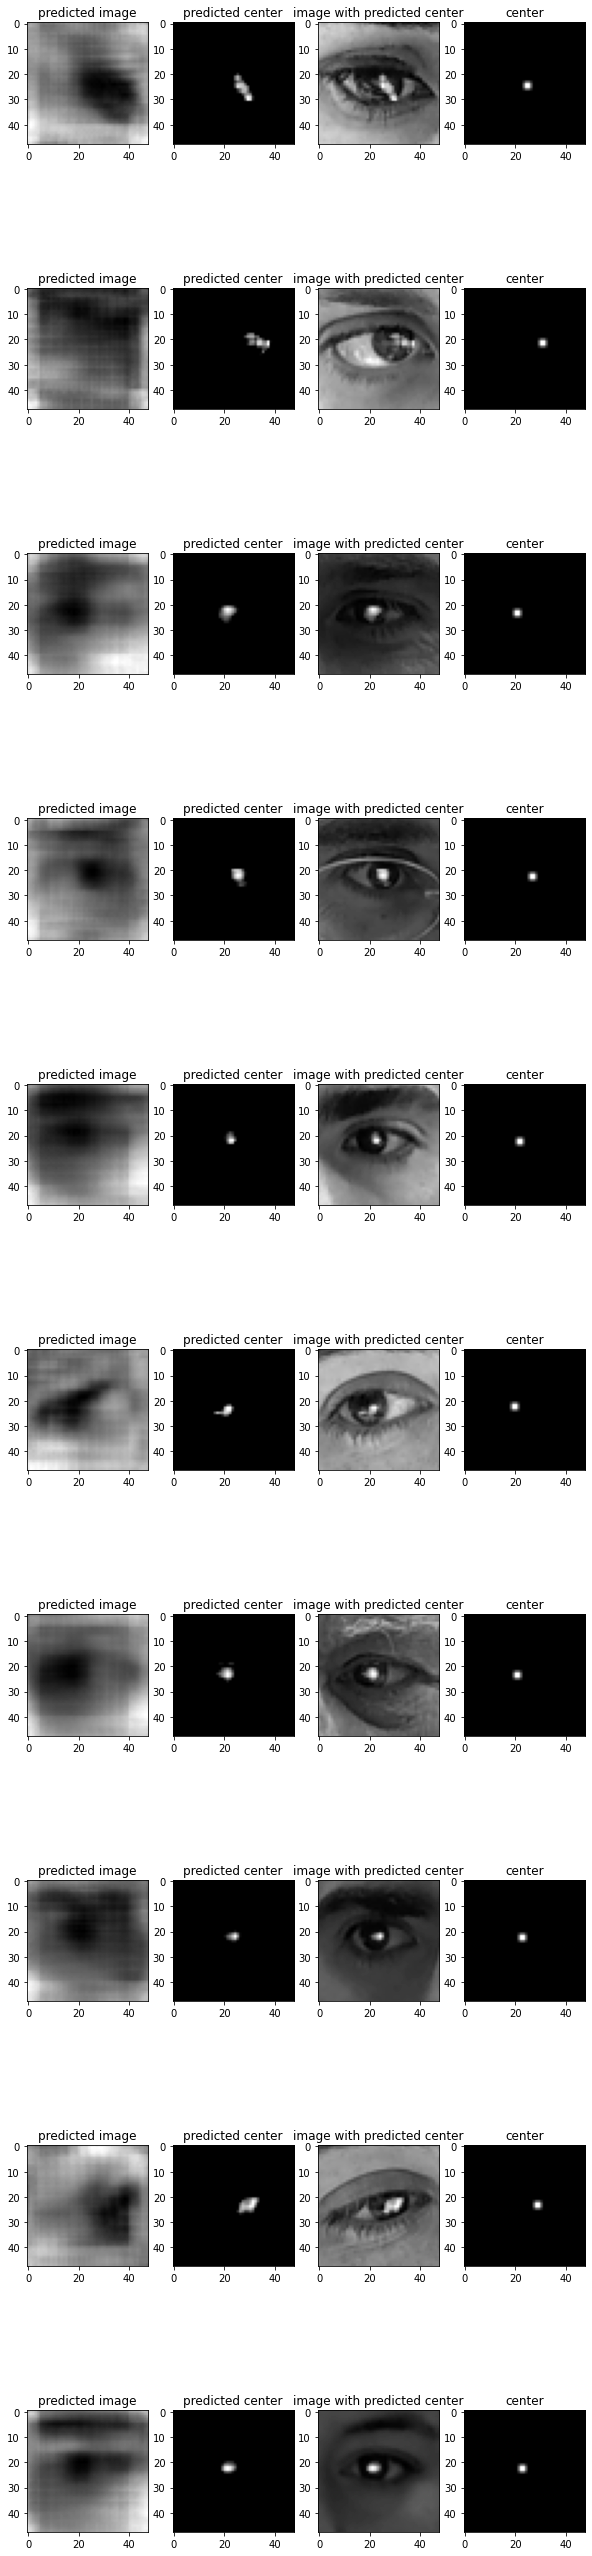

In [66]:
fig = plt.figure(figsize=(10, 48))
columns = 4
rows = 10
ax = []
dataloader_iterator = iter(test_data_loader)    
im_index=0
for i in range(rows):
    X, Y = next(dataloader_iterator)
    cent,image=net(X.to(device))
    pred_image=image[0,0,:,:].cpu().detach().numpy()
    pred_cent=cent[0,0,:,:].cpu().detach().numpy()
    ax.append( fig.add_subplot(rows, columns, im_index+1) )
    ax[-1].set_title('predicted image')
    plt.imshow(pred_image,cmap='gray')
    im_index+=1
    ax.append( fig.add_subplot(rows, columns, im_index+1) )
    ax[-1].set_title('predicted center')
    plt.imshow(pred_cent,cmap='gray')
    im_index+=1
    image=X[0,0,:,:].cpu().detach().numpy()
    cent=Y[0,0,:,:].cpu().detach().numpy()
    image=image+pred_cent/70
    ax.append( fig.add_subplot(rows, columns, im_index+1) )
    ax[-1].set_title('image with predicted center')
    plt.imshow(image,cmap='gray')
    im_index+=1
    ax.append( fig.add_subplot(rows, columns, im_index+1) )
    ax[-1].set_title('center')
    plt.imshow(cent,cmap='gray')
    im_index+=1

plt.show()




## we can see that the results are good and we can get better results if we do more epochs :)